# Assignment VIII: Deep Learning

## Question 1

Use the dataset, `DEMO_DATA/chinese_name_gender.txt` and create a Chinese name gender classifier using the deep learning method. You need to include a few important considerations in the creation of the deep learning classifer.

1. Please consult the lecture notes and experiment with different architectures of neural networks. In particular, please try combinations of the following types of network layers:

    - dense layer
    - embedding layer
    - RNN layer
    - bidirectional layer

2. Please include regularizations and dropbouts to avoid the issue of overfitting.
3. Please demonstrate how you find the optimal hyperparameters for the neural network using `keras-tuner`.
4. Please perform post-hoc analyses on a few cases using `LIME` for more interpretive results.



### Prepare Data

In [1]:
import numpy as np
import nltk
import random
import matplotlib

matplotlib.rcParams['figure.dpi'] = 150

In [2]:
with open("../../../RepositoryData/data/_ENC2045_DATA/chinese_name_gender_train.txt") as f:
    labeled_names = [l.replace('\n','').split(',') for l in f.readlines() if len(l.split(','))==2]

In [3]:
labeled_names =[(n, 1) if g=="男" else (n, 0) for n, g in labeled_names]

In [4]:
labeled_names[:10]

[('孫遠光', 1),
 ('吳昌財', 1),
 ('張俊達', 1),
 ('馬豔蘭', 0),
 ('宋燕敏', 0),
 ('徐安靜', 0),
 ('馬光美', 0),
 ('葉軍波', 1),
 ('孫婧倩', 0),
 ('朱清水', 1)]

In [5]:
random.shuffle(labeled_names)

### Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(labeled_names, test_size = 0.2, random_state=42)
print(len(train_set), len(test_set))

384000 96000


In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, RNN, GRU
from keras.layers import Embedding
from keras.layers import SpatialDropout1D

In [8]:
names = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set] 

In [9]:
len(names)

384000

In [10]:
nltk.FreqDist(labels)

FreqDist({0: 192032, 1: 191968})

### Tokenizer

- By default, the token index 0 is reserved for padding token.
- If `oov_token` is specified, it is default to index 1.
- Specify `num_words` for tokenizer to include only top N words in the model
- Tokenizer will automatically remove puntuations.
- Tokenizer use whitespace as word delimiter.
- If every character is treated as a token, specify `char_level=True`.

In [11]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(names)

### Prepare Input and Output Tensors

- Like in feature-based machine translation, a computational model only accepts numeric values. It is necessary to convert raw text to numeric tensor for neural network.
- After we create the Tokenizer, we use the Tokenizer to perform text vectorization, i.e., converting texts into tensors.
- In deep learning, words or characters are automatically converted into numeric representations.
- In other words, the feature engineering step is fully automatic.

### Two Ways of Text Vectorization

- Texts to Sequences: **Integer encoding** of tokens in texts and learn token **embeddings**
- Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)


### Method 1: Text to Sequences

### From Texts and Sequences

- Text to Sequences
- Padding to uniform lengths for each text

In [12]:
names_ints = tokenizer.texts_to_sequences(names)

In [13]:
print(names[:10])
print(names_ints[:10])
print(labels[:10])

['姚永建', '王彩文', '張賢芬', '黃燕玉', '韓志誠', '馬生蓮', '賈學東', '吳嘉靈', '姜漢卿', '嚴有爲']
[[164, 40, 36], [1, 204, 6], [3, 228, 92], [12, 37, 15], [97, 30, 520], [49, 70, 153], [216, 113, 59], [14, 184, 380], [180, 310, 459], [302, 288, 477]]
[1, 0, 0, 0, 1, 0, 1, 0, 1, 1]


### Vocabulary

In [14]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 2147


### Padding

- When padding the all texts into uniform lengths, consider whether to Pre-padding or removing values from the beginning of the sequence (i.e., `pre`) or the other way (`post`).
-  Check `padding` and `truncating` parameters in `pad_sequences`

姚永建


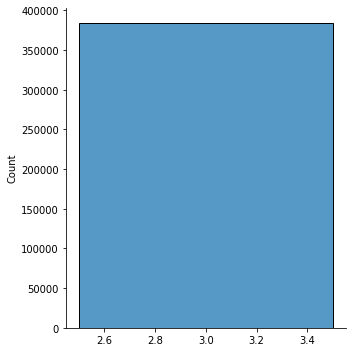

In [15]:
names_lens=[len(n) for n in names_ints]
names_lens
import seaborn as sns
sns.displot(names_lens)
print(names[np.argmax(names_lens)]) # longest name

In [16]:
max_len = names_lens[np.argmax(names_lens)]
max_len

3

In [17]:
names_ints_pad = sequence.pad_sequences(names_ints, maxlen = max_len)
names_ints_pad[:10]

array([[164,  40,  36],
       [  1, 204,   6],
       [  3, 228,  92],
       [ 12,  37,  15],
       [ 97,  30, 520],
       [ 49,  70, 153],
       [216, 113,  59],
       [ 14, 184, 380],
       [180, 310, 459],
       [302, 288, 477]], dtype=int32)

### Define X and Y

In [18]:
X_train = np.array(names_ints_pad).astype('int32')
y_train = np.array(labels)

X_test = np.array(sequence.pad_sequences(
    tokenizer.texts_to_sequences([n for (n,l) in test_set]),
    maxlen = max_len)).astype('int32')
y_test = np.array([l for (n,l) in test_set])

X_test_texts = [n for (n,l) in test_set]

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(384000, 3)
(384000,)
(96000, 3)
(96000,)


### Method 2: Text to Matrix

### One-Hot Encoding

- Text to Matrix (to create bag-of-word representation of each text)
- Choose modes: binary, count, or tfidf

In [20]:
names_matrix = tokenizer.texts_to_matrix(names, mode="binary")

In [21]:
names[2]

'張賢芬'

- `names_matrix` in fact is a bag-of-characters representation of a name text.

In [22]:
import pandas as pd
pd.DataFrame(names_matrix[2,1:], 
             columns=["ONE-HOT"],
             index=list(tokenizer.word_index.keys()))

ONE-HOT
王       0.0
李       0.0
張       1.0
陳       0.0
劉       0.0
..      ...
圍       0.0
巒       0.0
溟       0.0
詔       0.0
覓       0.0

[2146 rows x 1 columns]

### Define X and Y

In [23]:
X_train2 = np.array(names_matrix).astype('int32')
y_train2 = np.array(labels)

X_test2 = tokenizer.texts_to_matrix([n for (n,l) in test_set], mode="binary").astype('int32')
y_test2 = np.array([l for (n,l) in test_set])

X_test2_texts = [n for (n,l) in test_set]

In [24]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(384000, 2147)
(384000,)
(96000, 2147)
(96000,)


### Model Definition

- After we have defined our input and output tensors (X and y), we can define the architecture of our neural network model.
- For the two ways of name vectorized representations, we try two different network structures.
    - Text to Sequences: Embedding + RNN
    - Text to Matrix: Fully connected Dense Layers

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot1(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1: Fully Connected Dense Layers

- Two fully-connected dense layers with the Text-to-Matrix inputs

In [26]:
from keras import layers
model1 = keras.Sequential()
model1.add(keras.Input(shape=(vocab_size,), name="one_hot_input"))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model1.add(layers.Dense(1, activation="sigmoid", name="output"))

model1.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)


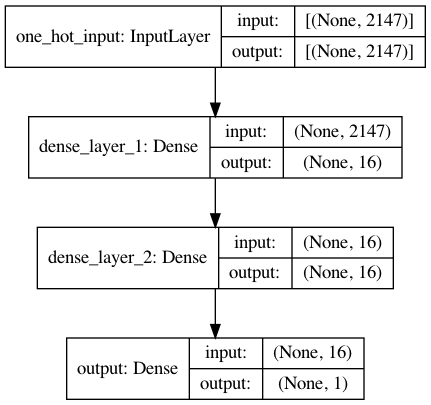

In [27]:
plot_model(model1, show_shapes=True)

### A few hyperparameters for network training

- Batch size
- Epoch
- Validation Split Ratio

In [28]:
BATCH_SIZE=1024
EPOCHS=5
VALIDATION_SPLIT=0.2

In [29]:
history1 = model1.fit(X_train2, y_train2, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/5
300/300 - 5s - loss: 0.2595 - accuracy: 0.9191 - val_loss: 0.0679 - val_accuracy: 0.9793
Epoch 2/5
300/300 - 3s - loss: 0.0573 - accuracy: 0.9815 - val_loss: 0.0551 - val_accuracy: 0.9812
Epoch 3/5
300/300 - 3s - loss: 0.0512 - accuracy: 0.9824 - val_loss: 0.0535 - val_accuracy: 0.9814
Epoch 4/5
300/300 - 3s - loss: 0.0493 - accuracy: 0.9830 - val_loss: 0.0522 - val_accuracy: 0.9818
Epoch 5/5
300/300 - 3s - loss: 0.0481 - accuracy: 0.9833 - val_loss: 0.0515 - val_accuracy: 0.9818


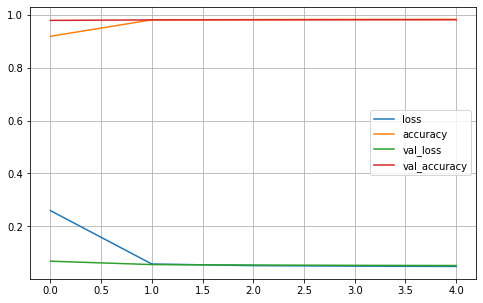

In [30]:
plot2(history1)

In [31]:
model1.evaluate(X_test2, y_test2, batch_size=128, verbose=2)

750/750 - 1s - loss: 0.0519 - accuracy: 0.9820


[0.051900025457143784, 0.9820104241371155]

### Model 2: Embedding + RNN

- One Embedding Layer + One RNN Layer 
- With Text-to-Sequence inputs

![](../images/name-gender-classifier-dl/name-gender-classifier-dl.004.jpeg)

In [32]:
EMBEDDING_DIM = 96

In [33]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, 
                     output_dim=EMBEDDING_DIM, 
                     input_length=max_len, 
                     mask_zero=True))
model2.add(layers.SimpleRNN(16, activation="relu", name="lstm_layer"))
model2.add(Dense(16, activation="relu", name="dense_layer"))
model2.add(Dense(1, activation="sigmoid", name="output"))

model2.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

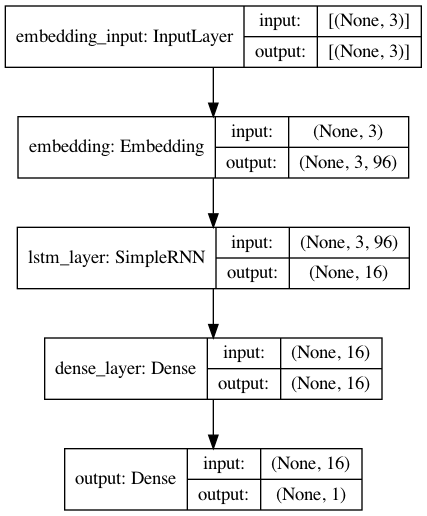

In [34]:
plot_model(model2, show_shapes=True)

In [35]:
history2 = model2.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/5
300/300 - 3s - loss: 0.1359 - accuracy: 0.9682 - val_loss: 0.0094 - val_accuracy: 0.9979
Epoch 2/5
300/300 - 2s - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0046 - val_accuracy: 0.9990
Epoch 3/5
300/300 - 2s - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0038 - val_accuracy: 0.9991
Epoch 4/5
300/300 - 1s - loss: 8.3264e-04 - accuracy: 0.9999 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 5/5
300/300 - 2s - loss: 4.8437e-04 - accuracy: 0.9999 - val_loss: 0.0039 - val_accuracy: 0.9991


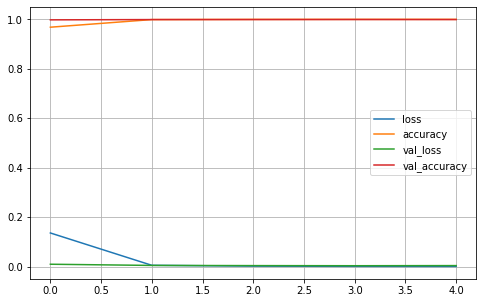

In [36]:
plot2(history2)

In [37]:
model2.evaluate(X_test, y_test, batch_size=128, verbose=2)

750/750 - 1s - loss: 0.0040 - accuracy: 0.9991


[0.003985119983553886, 0.9991250038146973]

### Model 3: Regularization and Dropout

- Previous two examples clearly show overfitting of the models because the model performance on the validation set starts to stall after the first few epochs.
- We can implement regularization and dropouts in our network definition to avoid overfitting.

In [38]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, 
                     output_dim=EMBEDDING_DIM, 
                     input_length=max_len, 
                     mask_zero=True))
model3.add(layers.SimpleRNN(16, activation="relu", name="lstm_layer", dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(16, activation="relu", name="dense_layer"))
model3.add(Dense(1, activation="sigmoid", name="output"))

model3.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

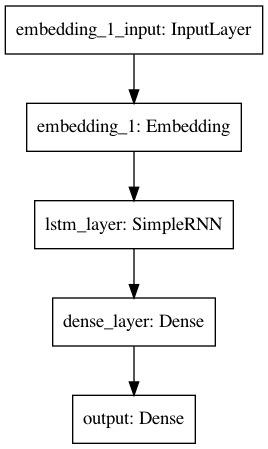

In [39]:
plot_model(model3)

In [40]:
history3 = model3.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/5
300/300 - 3s - loss: 0.1325 - accuracy: 0.9726 - val_loss: 0.0100 - val_accuracy: 0.9976
Epoch 2/5
300/300 - 2s - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.0054 - val_accuracy: 0.9988
Epoch 3/5
300/300 - 2s - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0046 - val_accuracy: 0.9989
Epoch 4/5
300/300 - 2s - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 5/5
300/300 - 2s - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0037 - val_accuracy: 0.9992


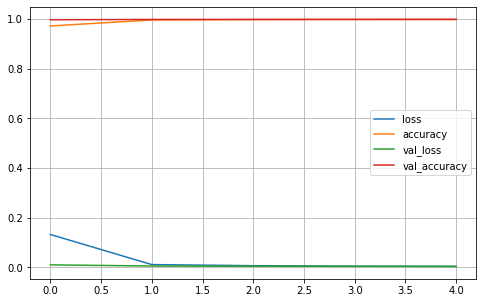

In [41]:
plot2(history3)

In [42]:
model3.evaluate(X_test, y_test, batch_size=128, verbose=2)

750/750 - 1s - loss: 0.0040 - accuracy: 0.9990


[0.00403445353731513, 0.9990312457084656]

### Model 4: Improve the Models

- In addition to regularization and dropouts, we can further improve the model by increasing the model complexity.
- In particular, we can increase the depths and widths of the network layers.
- Let's try stack two RNN layers.

In [43]:
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, 
                     output_dim=EMBEDDING_DIM, 
                     input_length=max_len, 
                     mask_zero=True))
model4.add(layers.SimpleRNN(16, activation="relu", name="lstm_layer_1", 
                            dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model4.add(layers.SimpleRNN(16, activation="relu", name="lstm_layer_2", 
                            dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid", name="output"))
model4.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

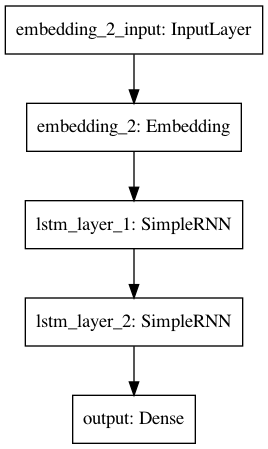

In [44]:
plot_model(model4)

In [45]:
history4 = model4.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/5
300/300 - 4s - loss: 0.1638 - accuracy: 0.9452 - val_loss: 0.0106 - val_accuracy: 0.9975
Epoch 2/5
300/300 - 2s - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0053 - val_accuracy: 0.9989
Epoch 3/5
300/300 - 2s - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0049 - val_accuracy: 0.9987
Epoch 4/5
300/300 - 2s - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 5/5
300/300 - 2s - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0039 - val_accuracy: 0.9991


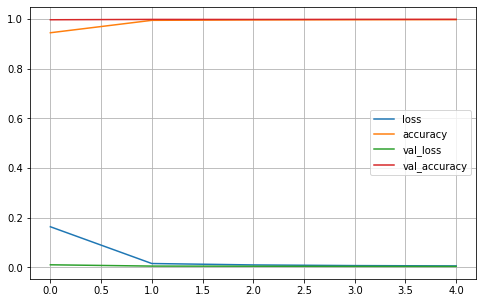

In [46]:
plot2(history4)

In [47]:
model4.evaluate(X_test, y_test, batch_size=128, verbose=2)

750/750 - 1s - loss: 0.0046 - accuracy: 0.9989


[0.004610829055309296, 0.9989270567893982]

### Model 5: Bidirectional

- Now let's try the more sophisticated RNN, LSTM, and with birectional computing.
- And add more nodes to the LSTM layer.

In [48]:
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, 
                     output_dim=EMBEDDING_DIM, 
                     input_length=max_len, 
                     mask_zero=True))
model5.add(layers.Bidirectional(LSTM(16, activation="relu", name="lstm_layer", dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(1, activation="sigmoid", name="output"))

model5.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

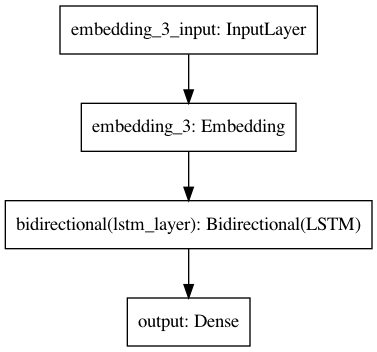

In [49]:
plot_model(model5)

In [50]:
history5 = model5.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/5
300/300 - 11s - loss: 0.1525 - accuracy: 0.9655 - val_loss: 0.0192 - val_accuracy: 0.9938
Epoch 2/5
300/300 - 6s - loss: 0.0148 - accuracy: 0.9950 - val_loss: 0.0110 - val_accuracy: 0.9967
Epoch 3/5
300/300 - 6s - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0063 - val_accuracy: 0.9985
Epoch 4/5
300/300 - 6s - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0048 - val_accuracy: 0.9989
Epoch 5/5
300/300 - 6s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0046 - val_accuracy: 0.9991


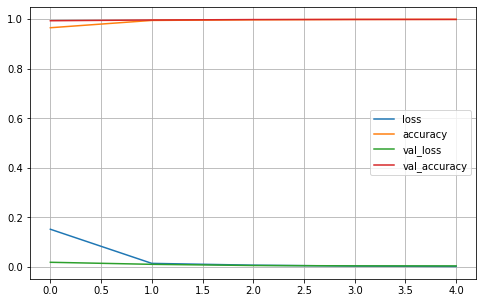

In [51]:
plot2(history5)

In [52]:
model5.evaluate(X_test, y_test, batch_size=128, verbose=2)

750/750 - 2s - loss: 0.0053 - accuracy: 0.9990


[0.005282292142510414, 0.9989687204360962]

### Check Embeddings

- Compared to one-hot encodings of characters, embeddings may include more information relating to the characteristics of the characters.
- We can extract the embedding layer and apply dimensional reduction techniques (i.e., TSNE) to see how embeddings capture the relationships in-between characters.

In [53]:
X_test[10]

array([129,  56,  35], dtype=int32)

In [54]:
ind2char = tokenizer.index_word
[ind2char.get(i) for i in X_test[10] if ind2char.get(i)!= None ]

['程', '雪', '平']

In [55]:
tokenizer.texts_to_sequences('Alvin')

[[], [], [], [], []]

In [56]:
char_vectors = model5.layers[0].get_weights()[0]
char_vectors.shape

(2147, 96)

In [57]:
labels = [char for (ind, char) in tokenizer.index_word.items()]
labels.insert(0,None)
labels

[None,
 '王',
 '李',
 '張',
 '陳',
 '劉',
 '文',
 '林',
 '楊',
 '華',
 '麗',
 '曉',
 '黃',
 '明',
 '吳',
 '玉',
 '紅',
 '英',
 '金',
 '周',
 '趙',
 '芳',
 '徐',
 '海',
 '春',
 '國',
 '梅',
 '玲',
 '偉',
 '朱',
 '志',
 '孫',
 '秀',
 '雲',
 '豔',
 '平',
 '建',
 '燕',
 '胡',
 '蘭',
 '永',
 '霞',
 '郭',
 '美',
 '鄭',
 '鳳',
 '龍',
 '軍',
 '萍',
 '馬',
 '榮',
 '高',
 '何',
 '娟',
 '德',
 '珍',
 '雪',
 '慧',
 '成',
 '東',
 '新',
 '子',
 '佳',
 '羅',
 '敏',
 '俊',
 '江',
 '世',
 '琴',
 '傑',
 '生',
 '輝',
 '洪',
 '亞',
 '清',
 '慶',
 '謝',
 '葉',
 '光',
 '梁',
 '強',
 '宋',
 '君',
 '淑',
 '婷',
 '許',
 '宇',
 '靜',
 '忠',
 '秋',
 '峯',
 '蔡',
 '芬',
 '桂',
 '利',
 '立',
 '瑞',
 '韓',
 '寶',
 '唐',
 '興',
 '飛',
 '家',
 '祥',
 '曹',
 '沈',
 '香',
 '花',
 '惠',
 '安',
 '方',
 '雅',
 '馮',
 '學',
 '青',
 '愛',
 '少',
 '娜',
 '福',
 '蘇',
 '鄧',
 '月',
 '良',
 '蔣',
 '思',
 '莉',
 '田',
 '曾',
 '潘',
 '程',
 '肖',
 '元',
 '波',
 '彭',
 '天',
 '正',
 '董',
 '丹',
 '鵬',
 '振',
 '夢',
 '大',
 '宏',
 '勇',
 '於',
 '武',
 '餘',
 '斌',
 '杜',
 '袁',
 '丁',
 '呂',
 '潔',
 '蓮',
 '民',
 '萬',
 '魏',
 '琳',
 '長',
 '超',
 '翠',
 '雨',
 '任',
 '亮',
 '姚',
 '濤',
 '素

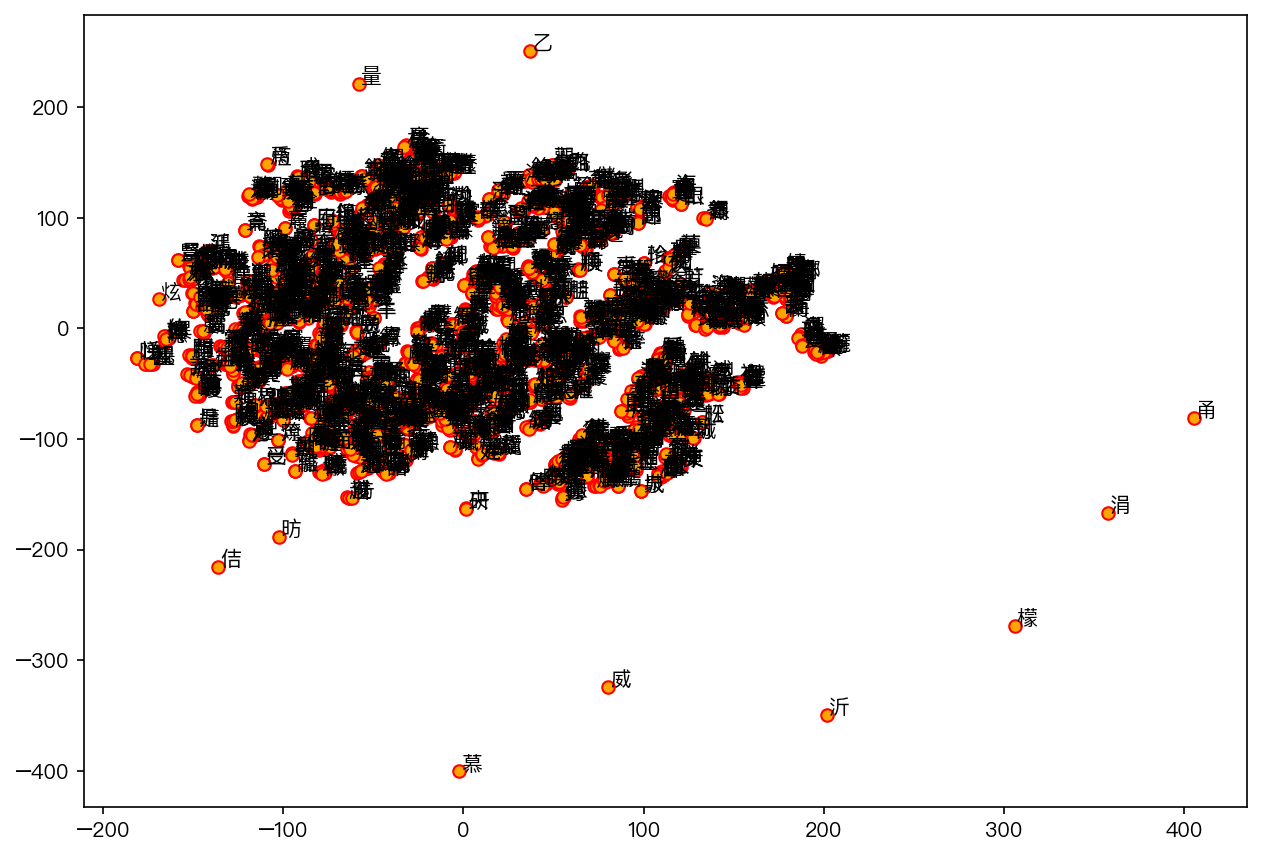

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(char_vectors)
labels = labels

plt.rcParams['font.sans-serif']=["PingFang HK"]

plt.figure(figsize=(10, 7), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Hyperparameter Tuning

:::{note}

Please install keras tuner module in your current conda:
```
pip install -U keras-tuner
```

:::

- Like feature-based ML methods, neural networks also come with many hyperparameters, which require default values.
- Typical hyperparameters include:
    - Number of nodes for the layer
    - Learning Rates
- We can utilize the module, [`keras-tuner`](https://keras-team.github.io/keras-tuner/documentation/tuners/), to fine-tune the hyperparameters.

- Steps for Keras Tuner
    - First, wrap the model definition in a function, which takes a single `hp` argument. 
    - Inside this function, replace any value we want to tune with a call to hyperparameter sampling methods, e.g. `hp.Int()` or `hp.Choice()`. The function should return a compiled model.
    - Next, instantiate a tuner object specifying your optimization objective and other search parameters.
    - Finally, start the search with the `search()` method, which takes the same arguments as `Model.fit()` in keras.
    - When search is over, we can retrieve the best model and a summary of the results from the `tunner`.


In [59]:
import kerastuner

In [60]:
## Wrap model definition in a function
## and specify the parameters needed for tuning
# def build_model(hp):
#     model1 = keras.Sequential()
#     model1.add(keras.Input(shape=(max_len,)))
#     model1.add(layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation="relu", name="dense_layer_1"))
#     model1.add(layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation="relu", name="dense_layer_2"))
#     model1.add(layers.Dense(2, activation="softmax", name="output"))
#     model1.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Choice('learning_rate',
#                       values=[1e-2, 1e-3, 1e-4])),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy'])
#     return model1

def build_model(hp):
    m= Sequential()
    m.add(Embedding(input_dim=vocab_size, 
                    output_dim=hp.Int('output_dim', min_value=16, max_value=128, step=16), 
                    input_length=max_len, 
                    mask_zero=True))
    m.add(layers.Bidirectional(LSTM(
        hp.Int('units', min_value=16, max_value=64, step=16),
        activation="relu", 
        dropout=0.2, 
        recurrent_dropout=0.2)))
    m.add(Dense(1, activation="sigmoid", name="output"))

    m.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(lr=0.001),
        metrics=["accuracy"]
    )
    return m

In [61]:
## This is to clean up the temp dir from the tuner
## Every time we re-start the tunner, it's better to keep the temp dir clean

import os
import shutil

if os.path.isdir('my_dir'):
    shutil.rmtree('my_dir')
    

- The `max_trials` variable represents the number of hyperparameter combinations that will be tested by the tuner.
- The `execution_per_trial` variable is the number of models that should be built and fit for each trial for robustness purposes.

In [62]:
## Instantiate the tunner

tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_accuracy',
  max_trials=10,
  executions_per_trial=2,
  directory='my_dir')

In [63]:
## Check the tuner's search space
tuner.search_space_summary()

In [64]:
%%time
## Start tuning with the tuner
tuner.search(X_train, y_train, validation_split=0.2, batch_size=128)

1608/2400 [===================>..........] - ETA: 2:25:05 - loss: 0.6932 - accuracy: 0.507 - ETA: 14s - loss: 0.6922 - accuracy: 0.5665    - ETA: 14s - loss: 0.6912 - accuracy: 0.612 - ETA: 14s - loss: 0.6900 - accuracy: 0.645 - ETA: 14s - loss: 0.6884 - accuracy: 0.672 - ETA: 14s - loss: 0.6863 - accuracy: 0.697 - ETA: 14s - loss: 0.6833 - accuracy: 0.717 - ETA: 13s - loss: 0.6787 - accuracy: 0.736 - ETA: 13s - loss: 0.6723 - accuracy: 0.751 - ETA: 13s - loss: 0.6638 - accuracy: 0.765 - ETA: 13s - loss: 0.6531 - accuracy: 0.776 - ETA: 13s - loss: 0.6406 - accuracy: 0.786 - ETA: 13s - loss: 0.6284 - accuracy: 0.794 - ETA: 13s - loss: 0.6185 - accuracy: 0.800 - ETA: 13s - loss: 0.6086 - accuracy: 0.806 - ETA: 13s - loss: 0.5987 - accuracy: 0.811 - ETA: 13s - loss: 0.5846 - accuracy: 0.817 - ETA: 13s - loss: 0.5709 - accuracy: 0.823 - ETA: 13s - loss: 0.5576 - accuracy: 0.829 - ETA: 12s - loss: 0.5448 - accuracy: 0.834 - ETA: 12s - loss: 0.5326 - accuracy: 0.839 - ETA: 12s - loss: 0.5209

2400/2400 [==============================] - ETA: 4s - loss: 0.1576 - accuracy: 0.95 - ETA: 4s - loss: 0.1573 - accuracy: 0.95 - ETA: 4s - loss: 0.1570 - accuracy: 0.95 - ETA: 4s - loss: 0.1565 - accuracy: 0.95 - ETA: 4s - loss: 0.1559 - accuracy: 0.95 - ETA: 4s - loss: 0.1553 - accuracy: 0.95 - ETA: 4s - loss: 0.1547 - accuracy: 0.95 - ETA: 4s - loss: 0.1541 - accuracy: 0.95 - ETA: 4s - loss: 0.1536 - accuracy: 0.95 - ETA: 4s - loss: 0.1529 - accuracy: 0.95 - ETA: 4s - loss: 0.1524 - accuracy: 0.95 - ETA: 4s - loss: 0.1518 - accuracy: 0.95 - ETA: 4s - loss: 0.1513 - accuracy: 0.95 - ETA: 4s - loss: 0.1509 - accuracy: 0.95 - ETA: 4s - loss: 0.1504 - accuracy: 0.95 - ETA: 4s - loss: 0.1499 - accuracy: 0.95 - ETA: 4s - loss: 0.1494 - accuracy: 0.95 - ETA: 3s - loss: 0.1489 - accuracy: 0.95 - ETA: 3s - loss: 0.1484 - accuracy: 0.95 - ETA: 3s - loss: 0.1479 - accuracy: 0.95 - ETA: 3s - loss: 0.1474 - accuracy: 0.95 - ETA: 3s - loss: 0.1469 - accuracy: 0.95 - ETA: 3s - loss: 0.1465 - accura

1752/2400 [====================>.........] - ETA: 2:26:40 - loss: 0.6925 - accuracy: 0.554 - ETA: 12s - loss: 0.6922 - accuracy: 0.5377    - ETA: 12s - loss: 0.6914 - accuracy: 0.573 - ETA: 13s - loss: 0.6904 - accuracy: 0.608 - ETA: 13s - loss: 0.6889 - accuracy: 0.642 - ETA: 12s - loss: 0.6864 - accuracy: 0.673 - ETA: 12s - loss: 0.6831 - accuracy: 0.695 - ETA: 12s - loss: 0.6783 - accuracy: 0.714 - ETA: 12s - loss: 0.6716 - accuracy: 0.730 - ETA: 12s - loss: 0.6625 - accuracy: 0.744 - ETA: 12s - loss: 0.6537 - accuracy: 0.754 - ETA: 12s - loss: 0.6413 - accuracy: 0.765 - ETA: 12s - loss: 0.6292 - accuracy: 0.773 - ETA: 12s - loss: 0.6153 - accuracy: 0.782 - ETA: 12s - loss: 0.6027 - accuracy: 0.790 - ETA: 12s - loss: 0.5903 - accuracy: 0.796 - ETA: 12s - loss: 0.5768 - accuracy: 0.803 - ETA: 12s - loss: 0.5637 - accuracy: 0.809 - ETA: 12s - loss: 0.5512 - accuracy: 0.815 - ETA: 12s - loss: 0.5390 - accuracy: 0.821 - ETA: 12s - loss: 0.5309 - accuracy: 0.824 - ETA: 12s - loss: 0.5196

1285/2400 [===============>..............] - ETA: 2:21:16 - loss: 0.6936 - accuracy: 0.445 - ETA: 16s - loss: 0.6925 - accuracy: 0.5489    - ETA: 16s - loss: 0.6917 - accuracy: 0.589 - ETA: 17s - loss: 0.6906 - accuracy: 0.619 - ETA: 17s - loss: 0.6891 - accuracy: 0.645 - ETA: 17s - loss: 0.6865 - accuracy: 0.670 - ETA: 17s - loss: 0.6830 - accuracy: 0.689 - ETA: 17s - loss: 0.6789 - accuracy: 0.703 - ETA: 17s - loss: 0.6710 - accuracy: 0.719 - ETA: 17s - loss: 0.6618 - accuracy: 0.732 - ETA: 17s - loss: 0.6506 - accuracy: 0.743 - ETA: 17s - loss: 0.6362 - accuracy: 0.755 - ETA: 17s - loss: 0.6209 - accuracy: 0.765 - ETA: 16s - loss: 0.6054 - accuracy: 0.775 - ETA: 16s - loss: 0.5919 - accuracy: 0.782 - ETA: 16s - loss: 0.5787 - accuracy: 0.789 - ETA: 16s - loss: 0.5677 - accuracy: 0.795 - ETA: 16s - loss: 0.5553 - accuracy: 0.801 - ETA: 16s - loss: 0.5418 - accuracy: 0.807 - ETA: 16s - loss: 0.5288 - accuracy: 0.813 - ETA: 16s - loss: 0.5165 - accuracy: 0.819 - ETA: 16s - loss: 0.5047

2400/2400 [==============================] - ETA: 8s - loss: 0.1535 - accuracy: 0.95 - ETA: 8s - loss: 0.1532 - accuracy: 0.95 - ETA: 8s - loss: 0.1528 - accuracy: 0.95 - ETA: 8s - loss: 0.1524 - accuracy: 0.95 - ETA: 8s - loss: 0.1519 - accuracy: 0.95 - ETA: 8s - loss: 0.1514 - accuracy: 0.95 - ETA: 8s - loss: 0.1509 - accuracy: 0.95 - ETA: 8s - loss: 0.1504 - accuracy: 0.95 - ETA: 8s - loss: 0.1499 - accuracy: 0.95 - ETA: 8s - loss: 0.1494 - accuracy: 0.95 - ETA: 8s - loss: 0.1490 - accuracy: 0.95 - ETA: 8s - loss: 0.1486 - accuracy: 0.95 - ETA: 8s - loss: 0.1481 - accuracy: 0.95 - ETA: 8s - loss: 0.1476 - accuracy: 0.95 - ETA: 7s - loss: 0.1471 - accuracy: 0.95 - ETA: 7s - loss: 0.1466 - accuracy: 0.95 - ETA: 7s - loss: 0.1461 - accuracy: 0.95 - ETA: 7s - loss: 0.1456 - accuracy: 0.95 - ETA: 7s - loss: 0.1452 - accuracy: 0.95 - ETA: 7s - loss: 0.1448 - accuracy: 0.95 - ETA: 7s - loss: 0.1444 - accuracy: 0.95 - ETA: 7s - loss: 0.1440 - accuracy: 0.95 - ETA: 7s - loss: 0.1435 - accura

1182/2400 [=============>................] - ETA: 2:42:21 - loss: 0.6931 - accuracy: 0.554 - ETA: 21s - loss: 0.6924 - accuracy: 0.5430    - ETA: 20s - loss: 0.6919 - accuracy: 0.529 - ETA: 22s - loss: 0.6913 - accuracy: 0.524 - ETA: 22s - loss: 0.6905 - accuracy: 0.526 - ETA: 23s - loss: 0.6898 - accuracy: 0.531 - ETA: 24s - loss: 0.6886 - accuracy: 0.542 - ETA: 23s - loss: 0.6866 - accuracy: 0.559 - ETA: 23s - loss: 0.6838 - accuracy: 0.575 - ETA: 22s - loss: 0.6797 - accuracy: 0.591 - ETA: 22s - loss: 0.6741 - accuracy: 0.607 - ETA: 22s - loss: 0.6682 - accuracy: 0.619 - ETA: 22s - loss: 0.6599 - accuracy: 0.632 - ETA: 22s - loss: 0.6502 - accuracy: 0.645 - ETA: 22s - loss: 0.6397 - accuracy: 0.656 - ETA: 21s - loss: 0.6286 - accuracy: 0.667 - ETA: 21s - loss: 0.6172 - accuracy: 0.677 - ETA: 21s - loss: 0.6058 - accuracy: 0.687 - ETA: 21s - loss: 0.5945 - accuracy: 0.695 - ETA: 21s - loss: 0.5853 - accuracy: 0.702 - ETA: 21s - loss: 0.5744 - accuracy: 0.710 - ETA: 21s - loss: 0.5638

1351/2400 [===============>..............] - ETA: 2:30:59 - loss: 0.6932 - accuracy: 0.523 - ETA: 17s - loss: 0.6932 - accuracy: 0.5052    - ETA: 20s - loss: 0.6929 - accuracy: 0.526 - ETA: 19s - loss: 0.6924 - accuracy: 0.548 - ETA: 19s - loss: 0.6917 - accuracy: 0.571 - ETA: 18s - loss: 0.6908 - accuracy: 0.595 - ETA: 18s - loss: 0.6895 - accuracy: 0.617 - ETA: 18s - loss: 0.6880 - accuracy: 0.633 - ETA: 18s - loss: 0.6849 - accuracy: 0.654 - ETA: 17s - loss: 0.6796 - accuracy: 0.673 - ETA: 16s - loss: 0.6716 - accuracy: 0.691 - ETA: 16s - loss: 0.6608 - accuracy: 0.706 - ETA: 16s - loss: 0.6494 - accuracy: 0.718 - ETA: 16s - loss: 0.6354 - accuracy: 0.731 - ETA: 15s - loss: 0.6209 - accuracy: 0.742 - ETA: 15s - loss: 0.6062 - accuracy: 0.752 - ETA: 15s - loss: 0.5934 - accuracy: 0.760 - ETA: 15s - loss: 0.5808 - accuracy: 0.767 - ETA: 15s - loss: 0.5701 - accuracy: 0.773 - ETA: 15s - loss: 0.5598 - accuracy: 0.779 - ETA: 15s - loss: 0.5497 - accuracy: 0.785 - ETA: 15s - loss: 0.5399

2400/2400 [==============================] - ETA: 7s - loss: 0.1664 - accuracy: 0.94 - ETA: 7s - loss: 0.1658 - accuracy: 0.94 - ETA: 7s - loss: 0.1654 - accuracy: 0.94 - ETA: 7s - loss: 0.1648 - accuracy: 0.94 - ETA: 7s - loss: 0.1643 - accuracy: 0.94 - ETA: 7s - loss: 0.1638 - accuracy: 0.94 - ETA: 7s - loss: 0.1633 - accuracy: 0.94 - ETA: 7s - loss: 0.1629 - accuracy: 0.94 - ETA: 7s - loss: 0.1625 - accuracy: 0.94 - ETA: 7s - loss: 0.1620 - accuracy: 0.94 - ETA: 7s - loss: 0.1615 - accuracy: 0.94 - ETA: 7s - loss: 0.1610 - accuracy: 0.94 - ETA: 7s - loss: 0.1605 - accuracy: 0.94 - ETA: 7s - loss: 0.1601 - accuracy: 0.94 - ETA: 6s - loss: 0.1596 - accuracy: 0.94 - ETA: 6s - loss: 0.1592 - accuracy: 0.94 - ETA: 6s - loss: 0.1588 - accuracy: 0.94 - ETA: 6s - loss: 0.1582 - accuracy: 0.94 - ETA: 6s - loss: 0.1577 - accuracy: 0.94 - ETA: 6s - loss: 0.1571 - accuracy: 0.94 - ETA: 6s - loss: 0.1566 - accuracy: 0.94 - ETA: 6s - loss: 0.1561 - accuracy: 0.94 - ETA: 6s - loss: 0.1557 - accura

1509/2400 [=================>............] - ETA: 2:22:18 - loss: 0.6938 - accuracy: 0.429 - ETA: 13s - loss: 0.6929 - accuracy: 0.5160    - ETA: 13s - loss: 0.6923 - accuracy: 0.543 - ETA: 13s - loss: 0.6914 - accuracy: 0.565 - ETA: 13s - loss: 0.6898 - accuracy: 0.593 - ETA: 13s - loss: 0.6873 - accuracy: 0.617 - ETA: 13s - loss: 0.6831 - accuracy: 0.638 - ETA: 13s - loss: 0.6766 - accuracy: 0.657 - ETA: 13s - loss: 0.6674 - accuracy: 0.674 - ETA: 13s - loss: 0.6556 - accuracy: 0.689 - ETA: 12s - loss: 0.6420 - accuracy: 0.703 - ETA: 12s - loss: 0.6274 - accuracy: 0.715 - ETA: 12s - loss: 0.6124 - accuracy: 0.726 - ETA: 12s - loss: 0.5973 - accuracy: 0.736 - ETA: 12s - loss: 0.5827 - accuracy: 0.746 - ETA: 12s - loss: 0.5685 - accuracy: 0.754 - ETA: 12s - loss: 0.5548 - accuracy: 0.762 - ETA: 12s - loss: 0.5418 - accuracy: 0.769 - ETA: 12s - loss: 0.5293 - accuracy: 0.776 - ETA: 12s - loss: 0.5174 - accuracy: 0.782 - ETA: 12s - loss: 0.5060 - accuracy: 0.788 - ETA: 12s - loss: 0.4952

1133/2400 [=============>................] - ETA: 2:32:18 - loss: 0.6934 - accuracy: 0.453 - ETA: 24s - loss: 0.6929 - accuracy: 0.5107    - ETA: 23s - loss: 0.6924 - accuracy: 0.549 - ETA: 20s - loss: 0.6917 - accuracy: 0.592 - ETA: 19s - loss: 0.6908 - accuracy: 0.628 - ETA: 18s - loss: 0.6892 - accuracy: 0.661 - ETA: 18s - loss: 0.6873 - accuracy: 0.681 - ETA: 19s - loss: 0.6846 - accuracy: 0.698 - ETA: 19s - loss: 0.6808 - accuracy: 0.713 - ETA: 19s - loss: 0.6755 - accuracy: 0.726 - ETA: 19s - loss: 0.6674 - accuracy: 0.740 - ETA: 18s - loss: 0.6572 - accuracy: 0.751 - ETA: 18s - loss: 0.6437 - accuracy: 0.763 - ETA: 18s - loss: 0.6310 - accuracy: 0.772 - ETA: 18s - loss: 0.6216 - accuracy: 0.779 - ETA: 19s - loss: 0.6140 - accuracy: 0.783 - ETA: 19s - loss: 0.6064 - accuracy: 0.787 - ETA: 19s - loss: 0.5970 - accuracy: 0.793 - ETA: 19s - loss: 0.5878 - accuracy: 0.797 - ETA: 19s - loss: 0.5769 - accuracy: 0.803 - ETA: 21s - loss: 0.5751 - accuracy: 0.804 - ETA: 22s - loss: 0.5716

2360/2400 [============================>.] - ETA: 11s - loss: 0.1686 - accuracy: 0.949 - ETA: 11s - loss: 0.1680 - accuracy: 0.949 - ETA: 10s - loss: 0.1674 - accuracy: 0.949 - ETA: 10s - loss: 0.1669 - accuracy: 0.949 - ETA: 10s - loss: 0.1663 - accuracy: 0.950 - ETA: 10s - loss: 0.1656 - accuracy: 0.950 - ETA: 10s - loss: 0.1650 - accuracy: 0.950 - ETA: 10s - loss: 0.1644 - accuracy: 0.950 - ETA: 10s - loss: 0.1640 - accuracy: 0.950 - ETA: 10s - loss: 0.1636 - accuracy: 0.950 - ETA: 10s - loss: 0.1632 - accuracy: 0.950 - ETA: 10s - loss: 0.1627 - accuracy: 0.951 - ETA: 10s - loss: 0.1624 - accuracy: 0.951 - ETA: 10s - loss: 0.1621 - accuracy: 0.951 - ETA: 10s - loss: 0.1615 - accuracy: 0.951 - ETA: 10s - loss: 0.1611 - accuracy: 0.951 - ETA: 10s - loss: 0.1606 - accuracy: 0.951 - ETA: 10s - loss: 0.1601 - accuracy: 0.951 - ETA: 10s - loss: 0.1597 - accuracy: 0.952 - ETA: 10s - loss: 0.1590 - accuracy: 0.952 - ETA: 10s - loss: 0.1586 - accuracy: 0.952 - ETA: 10s - loss: 0.1581 - accur

2400/2400 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - 27s 10ms/step - loss: 0.1058 - accuracy: 0.9682 - val_loss: 0.0080 - val_accuracy: 0.9982


1235/2400 [==============>...............] - ETA: 2:19:49 - loss: 0.6931 - accuracy: 0.507 - ETA: 18s - loss: 0.6925 - accuracy: 0.5189    - ETA: 19s - loss: 0.6920 - accuracy: 0.520 - ETA: 19s - loss: 0.6914 - accuracy: 0.520 - ETA: 19s - loss: 0.6907 - accuracy: 0.518 - ETA: 18s - loss: 0.6894 - accuracy: 0.524 - ETA: 18s - loss: 0.6879 - accuracy: 0.535 - ETA: 18s - loss: 0.6850 - accuracy: 0.551 - ETA: 18s - loss: 0.6820 - accuracy: 0.562 - ETA: 19s - loss: 0.6781 - accuracy: 0.574 - ETA: 19s - loss: 0.6708 - accuracy: 0.590 - ETA: 18s - loss: 0.6600 - accuracy: 0.607 - ETA: 18s - loss: 0.6487 - accuracy: 0.620 - ETA: 18s - loss: 0.6346 - accuracy: 0.635 - ETA: 18s - loss: 0.6219 - accuracy: 0.647 - ETA: 17s - loss: 0.6091 - accuracy: 0.658 - ETA: 18s - loss: 0.5982 - accuracy: 0.667 - ETA: 17s - loss: 0.5840 - accuracy: 0.678 - ETA: 18s - loss: 0.5753 - accuracy: 0.685 - ETA: 18s - loss: 0.5635 - accuracy: 0.693 - ETA: 18s - loss: 0.5522 - accuracy: 0.701 - ETA: 18s - loss: 0.5428

1234/2400 [==============>...............] - ETA: 2:27:08 - loss: 0.6938 - accuracy: 0.484 - ETA: 19s - loss: 0.6922 - accuracy: 0.5538    - ETA: 19s - loss: 0.6917 - accuracy: 0.551 - ETA: 20s - loss: 0.6910 - accuracy: 0.567 - ETA: 19s - loss: 0.6898 - accuracy: 0.593 - ETA: 19s - loss: 0.6885 - accuracy: 0.614 - ETA: 19s - loss: 0.6862 - accuracy: 0.637 - ETA: 19s - loss: 0.6830 - accuracy: 0.658 - ETA: 19s - loss: 0.6783 - accuracy: 0.676 - ETA: 18s - loss: 0.6718 - accuracy: 0.692 - ETA: 19s - loss: 0.6647 - accuracy: 0.704 - ETA: 18s - loss: 0.6532 - accuracy: 0.718 - ETA: 18s - loss: 0.6399 - accuracy: 0.731 - ETA: 17s - loss: 0.6257 - accuracy: 0.742 - ETA: 17s - loss: 0.6111 - accuracy: 0.752 - ETA: 17s - loss: 0.5983 - accuracy: 0.761 - ETA: 17s - loss: 0.5856 - accuracy: 0.768 - ETA: 17s - loss: 0.5733 - accuracy: 0.775 - ETA: 17s - loss: 0.5598 - accuracy: 0.783 - ETA: 17s - loss: 0.5483 - accuracy: 0.789 - ETA: 17s - loss: 0.5373 - accuracy: 0.794 - ETA: 16s - loss: 0.5252

2400/2400 [==============================] - ETA: 9s - loss: 0.1624 - accuracy: 0.94 - ETA: 9s - loss: 0.1618 - accuracy: 0.94 - ETA: 9s - loss: 0.1612 - accuracy: 0.94 - ETA: 9s - loss: 0.1606 - accuracy: 0.94 - ETA: 9s - loss: 0.1600 - accuracy: 0.94 - ETA: 9s - loss: 0.1594 - accuracy: 0.94 - ETA: 8s - loss: 0.1587 - accuracy: 0.94 - ETA: 8s - loss: 0.1581 - accuracy: 0.94 - ETA: 8s - loss: 0.1575 - accuracy: 0.94 - ETA: 8s - loss: 0.1569 - accuracy: 0.94 - ETA: 8s - loss: 0.1563 - accuracy: 0.94 - ETA: 8s - loss: 0.1558 - accuracy: 0.94 - ETA: 8s - loss: 0.1552 - accuracy: 0.94 - ETA: 8s - loss: 0.1546 - accuracy: 0.94 - ETA: 8s - loss: 0.1540 - accuracy: 0.94 - ETA: 8s - loss: 0.1535 - accuracy: 0.94 - ETA: 8s - loss: 0.1529 - accuracy: 0.94 - ETA: 8s - loss: 0.1524 - accuracy: 0.94 - ETA: 8s - loss: 0.1518 - accuracy: 0.94 - ETA: 8s - loss: 0.1513 - accuracy: 0.94 - ETA: 7s - loss: 0.1507 - accuracy: 0.94 - ETA: 7s - loss: 0.1502 - accuracy: 0.94 - ETA: 7s - loss: 0.1497 - accura

1195/2400 [=============>................] - ETA: 2:41:57 - loss: 0.6934 - accuracy: 0.507 - ETA: 17s - loss: 0.6928 - accuracy: 0.5270    - ETA: 20s - loss: 0.6923 - accuracy: 0.556 - ETA: 21s - loss: 0.6916 - accuracy: 0.584 - ETA: 21s - loss: 0.6908 - accuracy: 0.610 - ETA: 21s - loss: 0.6898 - accuracy: 0.634 - ETA: 20s - loss: 0.6881 - accuracy: 0.659 - ETA: 20s - loss: 0.6851 - accuracy: 0.682 - ETA: 21s - loss: 0.6830 - accuracy: 0.692 - ETA: 23s - loss: 0.6811 - accuracy: 0.699 - ETA: 23s - loss: 0.6781 - accuracy: 0.708 - ETA: 23s - loss: 0.6733 - accuracy: 0.719 - ETA: 23s - loss: 0.6663 - accuracy: 0.730 - ETA: 22s - loss: 0.6548 - accuracy: 0.743 - ETA: 22s - loss: 0.6433 - accuracy: 0.753 - ETA: 21s - loss: 0.6310 - accuracy: 0.763 - ETA: 21s - loss: 0.6202 - accuracy: 0.770 - ETA: 21s - loss: 0.6093 - accuracy: 0.777 - ETA: 21s - loss: 0.5984 - accuracy: 0.783 - ETA: 21s - loss: 0.5878 - accuracy: 0.789 - ETA: 21s - loss: 0.5757 - accuracy: 0.795 - ETA: 21s - loss: 0.5640

1503/2400 [=================>............] - ETA: 2:24:15 - loss: 0.6924 - accuracy: 0.554 - ETA: 17s - loss: 0.6924 - accuracy: 0.5197    - ETA: 18s - loss: 0.6916 - accuracy: 0.533 - ETA: 18s - loss: 0.6907 - accuracy: 0.550 - ETA: 17s - loss: 0.6895 - accuracy: 0.570 - ETA: 17s - loss: 0.6877 - accuracy: 0.591 - ETA: 16s - loss: 0.6851 - accuracy: 0.612 - ETA: 16s - loss: 0.6818 - accuracy: 0.628 - ETA: 16s - loss: 0.6764 - accuracy: 0.646 - ETA: 16s - loss: 0.6691 - accuracy: 0.662 - ETA: 16s - loss: 0.6597 - accuracy: 0.677 - ETA: 15s - loss: 0.6485 - accuracy: 0.690 - ETA: 15s - loss: 0.6360 - accuracy: 0.702 - ETA: 15s - loss: 0.6230 - accuracy: 0.713 - ETA: 15s - loss: 0.6097 - accuracy: 0.723 - ETA: 15s - loss: 0.5966 - accuracy: 0.732 - ETA: 15s - loss: 0.5836 - accuracy: 0.741 - ETA: 15s - loss: 0.5709 - accuracy: 0.749 - ETA: 15s - loss: 0.5587 - accuracy: 0.756 - ETA: 15s - loss: 0.5468 - accuracy: 0.763 - ETA: 15s - loss: 0.5355 - accuracy: 0.769 - ETA: 15s - loss: 0.5246

2400/2400 [==============================] - ETA: 5s - loss: 0.1521 - accuracy: 0.94 - ETA: 5s - loss: 0.1517 - accuracy: 0.94 - ETA: 5s - loss: 0.1513 - accuracy: 0.94 - ETA: 5s - loss: 0.1509 - accuracy: 0.94 - ETA: 5s - loss: 0.1504 - accuracy: 0.94 - ETA: 5s - loss: 0.1500 - accuracy: 0.94 - ETA: 5s - loss: 0.1495 - accuracy: 0.94 - ETA: 5s - loss: 0.1490 - accuracy: 0.94 - ETA: 5s - loss: 0.1485 - accuracy: 0.94 - ETA: 5s - loss: 0.1480 - accuracy: 0.94 - ETA: 5s - loss: 0.1476 - accuracy: 0.94 - ETA: 5s - loss: 0.1473 - accuracy: 0.94 - ETA: 5s - loss: 0.1471 - accuracy: 0.94 - ETA: 5s - loss: 0.1467 - accuracy: 0.94 - ETA: 5s - loss: 0.1464 - accuracy: 0.94 - ETA: 5s - loss: 0.1460 - accuracy: 0.94 - ETA: 5s - loss: 0.1455 - accuracy: 0.94 - ETA: 5s - loss: 0.1451 - accuracy: 0.94 - ETA: 5s - loss: 0.1447 - accuracy: 0.94 - ETA: 5s - loss: 0.1442 - accuracy: 0.94 - ETA: 5s - loss: 0.1438 - accuracy: 0.94 - ETA: 5s - loss: 0.1434 - accuracy: 0.94 - ETA: 4s - loss: 0.1430 - accura

1466/2400 [=================>............] - ETA: 2:22:41 - loss: 0.6935 - accuracy: 0.445 - ETA: 15s - loss: 0.6925 - accuracy: 0.5486    - ETA: 15s - loss: 0.6915 - accuracy: 0.596 - ETA: 14s - loss: 0.6902 - accuracy: 0.639 - ETA: 14s - loss: 0.6884 - accuracy: 0.672 - ETA: 14s - loss: 0.6856 - accuracy: 0.698 - ETA: 13s - loss: 0.6813 - accuracy: 0.719 - ETA: 14s - loss: 0.6757 - accuracy: 0.735 - ETA: 14s - loss: 0.6681 - accuracy: 0.749 - ETA: 13s - loss: 0.6569 - accuracy: 0.763 - ETA: 13s - loss: 0.6421 - accuracy: 0.775 - ETA: 13s - loss: 0.6276 - accuracy: 0.785 - ETA: 13s - loss: 0.6126 - accuracy: 0.794 - ETA: 13s - loss: 0.5976 - accuracy: 0.802 - ETA: 13s - loss: 0.5813 - accuracy: 0.811 - ETA: 13s - loss: 0.5671 - accuracy: 0.817 - ETA: 13s - loss: 0.5549 - accuracy: 0.823 - ETA: 13s - loss: 0.5418 - accuracy: 0.828 - ETA: 13s - loss: 0.5292 - accuracy: 0.833 - ETA: 13s - loss: 0.5172 - accuracy: 0.838 - ETA: 13s - loss: 0.5057 - accuracy: 0.843 - ETA: 13s - loss: 0.4947

1605/2400 [===================>..........] - ETA: 2:18:55 - loss: 0.6934 - accuracy: 0.531 - ETA: 11s - loss: 0.6927 - accuracy: 0.5435    - ETA: 13s - loss: 0.6919 - accuracy: 0.584 - ETA: 12s - loss: 0.6906 - accuracy: 0.623 - ETA: 12s - loss: 0.6887 - accuracy: 0.649 - ETA: 12s - loss: 0.6858 - accuracy: 0.669 - ETA: 12s - loss: 0.6824 - accuracy: 0.683 - ETA: 12s - loss: 0.6761 - accuracy: 0.698 - ETA: 12s - loss: 0.6664 - accuracy: 0.714 - ETA: 12s - loss: 0.6549 - accuracy: 0.726 - ETA: 12s - loss: 0.6415 - accuracy: 0.738 - ETA: 12s - loss: 0.6254 - accuracy: 0.749 - ETA: 11s - loss: 0.6088 - accuracy: 0.760 - ETA: 11s - loss: 0.5938 - accuracy: 0.768 - ETA: 11s - loss: 0.5791 - accuracy: 0.776 - ETA: 11s - loss: 0.5650 - accuracy: 0.783 - ETA: 11s - loss: 0.5501 - accuracy: 0.791 - ETA: 11s - loss: 0.5359 - accuracy: 0.798 - ETA: 11s - loss: 0.5248 - accuracy: 0.803 - ETA: 11s - loss: 0.5130 - accuracy: 0.808 - ETA: 11s - loss: 0.5006 - accuracy: 0.814 - ETA: 11s - loss: 0.4889

2400/2400 [==============================] - ETA: 4s - loss: 0.1552 - accuracy: 0.94 - ETA: 4s - loss: 0.1547 - accuracy: 0.94 - ETA: 4s - loss: 0.1542 - accuracy: 0.94 - ETA: 4s - loss: 0.1537 - accuracy: 0.94 - ETA: 4s - loss: 0.1531 - accuracy: 0.94 - ETA: 4s - loss: 0.1526 - accuracy: 0.94 - ETA: 4s - loss: 0.1521 - accuracy: 0.94 - ETA: 4s - loss: 0.1516 - accuracy: 0.94 - ETA: 4s - loss: 0.1511 - accuracy: 0.94 - ETA: 4s - loss: 0.1506 - accuracy: 0.94 - ETA: 4s - loss: 0.1500 - accuracy: 0.94 - ETA: 4s - loss: 0.1495 - accuracy: 0.94 - ETA: 4s - loss: 0.1490 - accuracy: 0.94 - ETA: 4s - loss: 0.1484 - accuracy: 0.94 - ETA: 4s - loss: 0.1481 - accuracy: 0.94 - ETA: 4s - loss: 0.1475 - accuracy: 0.94 - ETA: 3s - loss: 0.1470 - accuracy: 0.95 - ETA: 3s - loss: 0.1466 - accuracy: 0.95 - ETA: 3s - loss: 0.1462 - accuracy: 0.95 - ETA: 3s - loss: 0.1459 - accuracy: 0.95 - ETA: 3s - loss: 0.1456 - accuracy: 0.95 - ETA: 3s - loss: 0.1452 - accuracy: 0.95 - ETA: 3s - loss: 0.1449 - accura

1408/2400 [================>.............] - ETA: 2:20:37 - loss: 0.6936 - accuracy: 0.460 - ETA: 14s - loss: 0.6929 - accuracy: 0.5044    - ETA: 14s - loss: 0.6923 - accuracy: 0.535 - ETA: 14s - loss: 0.6915 - accuracy: 0.569 - ETA: 14s - loss: 0.6905 - accuracy: 0.601 - ETA: 13s - loss: 0.6887 - accuracy: 0.632 - ETA: 13s - loss: 0.6862 - accuracy: 0.656 - ETA: 13s - loss: 0.6823 - accuracy: 0.676 - ETA: 13s - loss: 0.6758 - accuracy: 0.696 - ETA: 13s - loss: 0.6666 - accuracy: 0.712 - ETA: 12s - loss: 0.6548 - accuracy: 0.727 - ETA: 13s - loss: 0.6455 - accuracy: 0.736 - ETA: 13s - loss: 0.6356 - accuracy: 0.744 - ETA: 13s - loss: 0.6268 - accuracy: 0.751 - ETA: 13s - loss: 0.6120 - accuracy: 0.761 - ETA: 13s - loss: 0.6017 - accuracy: 0.768 - ETA: 13s - loss: 0.5914 - accuracy: 0.774 - ETA: 13s - loss: 0.5814 - accuracy: 0.780 - ETA: 13s - loss: 0.5689 - accuracy: 0.786 - ETA: 13s - loss: 0.5554 - accuracy: 0.793 - ETA: 13s - loss: 0.5425 - accuracy: 0.800 - ETA: 13s - loss: 0.5338

1078/2400 [============>.................] - ETA: 2:19:27 - loss: 0.6933 - accuracy: 0.453 - ETA: 19s - loss: 0.6923 - accuracy: 0.5204    - ETA: 19s - loss: 0.6913 - accuracy: 0.576 - ETA: 20s - loss: 0.6903 - accuracy: 0.609 - ETA: 21s - loss: 0.6892 - accuracy: 0.635 - ETA: 22s - loss: 0.6878 - accuracy: 0.657 - ETA: 22s - loss: 0.6855 - accuracy: 0.679 - ETA: 23s - loss: 0.6828 - accuracy: 0.695 - ETA: 23s - loss: 0.6793 - accuracy: 0.709 - ETA: 23s - loss: 0.6747 - accuracy: 0.722 - ETA: 23s - loss: 0.6677 - accuracy: 0.735 - ETA: 23s - loss: 0.6606 - accuracy: 0.744 - ETA: 23s - loss: 0.6523 - accuracy: 0.753 - ETA: 25s - loss: 0.6505 - accuracy: 0.755 - ETA: 25s - loss: 0.6450 - accuracy: 0.760 - ETA: 25s - loss: 0.6353 - accuracy: 0.767 - ETA: 25s - loss: 0.6232 - accuracy: 0.775 - ETA: 25s - loss: 0.6109 - accuracy: 0.783 - ETA: 24s - loss: 0.5987 - accuracy: 0.790 - ETA: 24s - loss: 0.5866 - accuracy: 0.796 - ETA: 24s - loss: 0.5748 - accuracy: 0.802 - ETA: 23s - loss: 0.5634

2266/2400 [===========================>..] - ETA: 12s - loss: 0.1642 - accuracy: 0.950 - ETA: 12s - loss: 0.1635 - accuracy: 0.950 - ETA: 12s - loss: 0.1629 - accuracy: 0.950 - ETA: 12s - loss: 0.1623 - accuracy: 0.950 - ETA: 12s - loss: 0.1617 - accuracy: 0.950 - ETA: 12s - loss: 0.1612 - accuracy: 0.951 - ETA: 11s - loss: 0.1606 - accuracy: 0.951 - ETA: 11s - loss: 0.1601 - accuracy: 0.951 - ETA: 11s - loss: 0.1596 - accuracy: 0.951 - ETA: 11s - loss: 0.1590 - accuracy: 0.951 - ETA: 11s - loss: 0.1584 - accuracy: 0.951 - ETA: 11s - loss: 0.1578 - accuracy: 0.952 - ETA: 11s - loss: 0.1572 - accuracy: 0.952 - ETA: 11s - loss: 0.1566 - accuracy: 0.952 - ETA: 11s - loss: 0.1560 - accuracy: 0.952 - ETA: 11s - loss: 0.1555 - accuracy: 0.952 - ETA: 11s - loss: 0.1550 - accuracy: 0.952 - ETA: 11s - loss: 0.1544 - accuracy: 0.953 - ETA: 11s - loss: 0.1539 - accuracy: 0.953 - ETA: 11s - loss: 0.1533 - accuracy: 0.953 - ETA: 11s - loss: 0.1528 - accuracy: 0.953 - ETA: 10s - loss: 0.1523 - accur

2400/2400 [==============================] - ETA: 1s - loss: 0.1033 - accuracy: 0.96 - ETA: 1s - loss: 0.1031 - accuracy: 0.96 - ETA: 1s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - 27s 10ms/step - loss: 0.0997 - accuracy: 0.9697 - val_loss: 0.0066 - val_

1050/2400 [============>.................] - ETA: 2:20:00 - loss: 0.6931 - accuracy: 0.507 - ETA: 19s - loss: 0.6923 - accuracy: 0.5343    - ETA: 20s - loss: 0.6914 - accuracy: 0.574 - ETA: 20s - loss: 0.6904 - accuracy: 0.609 - ETA: 20s - loss: 0.6891 - accuracy: 0.638 - ETA: 21s - loss: 0.6874 - accuracy: 0.662 - ETA: 20s - loss: 0.6850 - accuracy: 0.683 - ETA: 20s - loss: 0.6816 - accuracy: 0.700 - ETA: 21s - loss: 0.6777 - accuracy: 0.713 - ETA: 20s - loss: 0.6705 - accuracy: 0.728 - ETA: 20s - loss: 0.6610 - accuracy: 0.742 - ETA: 20s - loss: 0.6510 - accuracy: 0.752 - ETA: 20s - loss: 0.6419 - accuracy: 0.760 - ETA: 20s - loss: 0.6303 - accuracy: 0.768 - ETA: 20s - loss: 0.6163 - accuracy: 0.777 - ETA: 20s - loss: 0.6042 - accuracy: 0.784 - ETA: 21s - loss: 0.5962 - accuracy: 0.788 - ETA: 21s - loss: 0.5882 - accuracy: 0.793 - ETA: 21s - loss: 0.5746 - accuracy: 0.799 - ETA: 21s - loss: 0.5615 - accuracy: 0.806 - ETA: 21s - loss: 0.5506 - accuracy: 0.811 - ETA: 21s - loss: 0.5401

2400/2400 [==============================] - ETA: 1s - loss: 0.1046 - accuracy: 0.96 - ETA: 1s - loss: 0.1044 - accuracy: 0.96 - ETA: 1s - loss: 0.1041 - accuracy: 0.96 - ETA: 1s - loss: 0.1039 - accuracy: 0.96 - ETA: 1s - loss: 0.1038 - accuracy: 0.96 - ETA: 1s - loss: 0.1035 - accuracy: 0.96 - ETA: 1s - loss: 0.1033 - accuracy: 0.96 - ETA: 1s - loss: 0.1031 - accuracy: 0.96 - ETA: 1s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accura

1375/2400 [================>.............] - ETA: 2:23:23 - loss: 0.6929 - accuracy: 0.531 - ETA: 15s - loss: 0.6928 - accuracy: 0.5055    - ETA: 15s - loss: 0.6924 - accuracy: 0.509 - ETA: 14s - loss: 0.6916 - accuracy: 0.517 - ETA: 15s - loss: 0.6909 - accuracy: 0.522 - ETA: 15s - loss: 0.6894 - accuracy: 0.535 - ETA: 15s - loss: 0.6870 - accuracy: 0.550 - ETA: 15s - loss: 0.6841 - accuracy: 0.564 - ETA: 15s - loss: 0.6798 - accuracy: 0.577 - ETA: 15s - loss: 0.6739 - accuracy: 0.590 - ETA: 15s - loss: 0.6651 - accuracy: 0.605 - ETA: 15s - loss: 0.6545 - accuracy: 0.619 - ETA: 15s - loss: 0.6424 - accuracy: 0.632 - ETA: 15s - loss: 0.6312 - accuracy: 0.642 - ETA: 15s - loss: 0.6182 - accuracy: 0.654 - ETA: 15s - loss: 0.6034 - accuracy: 0.666 - ETA: 15s - loss: 0.5890 - accuracy: 0.677 - ETA: 15s - loss: 0.5765 - accuracy: 0.686 - ETA: 15s - loss: 0.5659 - accuracy: 0.694 - ETA: 15s - loss: 0.5541 - accuracy: 0.702 - ETA: 15s - loss: 0.5442 - accuracy: 0.709 - ETA: 15s - loss: 0.5346

2400/2400 [==============================] - ETA: 7s - loss: 0.1639 - accuracy: 0.92 - ETA: 7s - loss: 0.1633 - accuracy: 0.92 - ETA: 7s - loss: 0.1628 - accuracy: 0.92 - ETA: 7s - loss: 0.1624 - accuracy: 0.92 - ETA: 7s - loss: 0.1618 - accuracy: 0.92 - ETA: 7s - loss: 0.1612 - accuracy: 0.92 - ETA: 7s - loss: 0.1606 - accuracy: 0.92 - ETA: 6s - loss: 0.1601 - accuracy: 0.92 - ETA: 6s - loss: 0.1595 - accuracy: 0.92 - ETA: 6s - loss: 0.1591 - accuracy: 0.92 - ETA: 6s - loss: 0.1586 - accuracy: 0.92 - ETA: 6s - loss: 0.1582 - accuracy: 0.92 - ETA: 6s - loss: 0.1580 - accuracy: 0.92 - ETA: 6s - loss: 0.1575 - accuracy: 0.92 - ETA: 6s - loss: 0.1573 - accuracy: 0.92 - ETA: 6s - loss: 0.1570 - accuracy: 0.92 - ETA: 6s - loss: 0.1566 - accuracy: 0.92 - ETA: 6s - loss: 0.1561 - accuracy: 0.92 - ETA: 6s - loss: 0.1557 - accuracy: 0.92 - ETA: 6s - loss: 0.1551 - accuracy: 0.92 - ETA: 6s - loss: 0.1546 - accuracy: 0.92 - ETA: 6s - loss: 0.1540 - accuracy: 0.92 - ETA: 6s - loss: 0.1535 - accura

1444/2400 [=================>............] - ETA: 2:21:17 - loss: 0.6932 - accuracy: 0.500 - ETA: 14s - loss: 0.6928 - accuracy: 0.5153    - ETA: 15s - loss: 0.6924 - accuracy: 0.554 - ETA: 14s - loss: 0.6916 - accuracy: 0.586 - ETA: 14s - loss: 0.6903 - accuracy: 0.611 - ETA: 14s - loss: 0.6884 - accuracy: 0.632 - ETA: 14s - loss: 0.6846 - accuracy: 0.654 - ETA: 14s - loss: 0.6786 - accuracy: 0.673 - ETA: 14s - loss: 0.6697 - accuracy: 0.690 - ETA: 14s - loss: 0.6607 - accuracy: 0.701 - ETA: 14s - loss: 0.6487 - accuracy: 0.714 - ETA: 14s - loss: 0.6356 - accuracy: 0.725 - ETA: 14s - loss: 0.6219 - accuracy: 0.735 - ETA: 14s - loss: 0.6064 - accuracy: 0.746 - ETA: 14s - loss: 0.5911 - accuracy: 0.755 - ETA: 14s - loss: 0.5780 - accuracy: 0.763 - ETA: 14s - loss: 0.5636 - accuracy: 0.771 - ETA: 14s - loss: 0.5499 - accuracy: 0.778 - ETA: 14s - loss: 0.5368 - accuracy: 0.785 - ETA: 14s - loss: 0.5270 - accuracy: 0.790 - ETA: 14s - loss: 0.5162 - accuracy: 0.795 - ETA: 14s - loss: 0.5059

1518/2400 [=================>............] - ETA: 2:18:01 - loss: 0.6933 - accuracy: 0.515 - ETA: 12s - loss: 0.6922 - accuracy: 0.5824    - ETA: 12s - loss: 0.6912 - accuracy: 0.620 - ETA: 12s - loss: 0.6898 - accuracy: 0.656 - ETA: 12s - loss: 0.6876 - accuracy: 0.684 - ETA: 12s - loss: 0.6840 - accuracy: 0.707 - ETA: 12s - loss: 0.6782 - accuracy: 0.727 - ETA: 12s - loss: 0.6698 - accuracy: 0.743 - ETA: 12s - loss: 0.6584 - accuracy: 0.757 - ETA: 12s - loss: 0.6446 - accuracy: 0.769 - ETA: 12s - loss: 0.6292 - accuracy: 0.780 - ETA: 12s - loss: 0.6131 - accuracy: 0.789 - ETA: 12s - loss: 0.5970 - accuracy: 0.798 - ETA: 12s - loss: 0.5811 - accuracy: 0.806 - ETA: 12s - loss: 0.5658 - accuracy: 0.813 - ETA: 12s - loss: 0.5511 - accuracy: 0.820 - ETA: 12s - loss: 0.5385 - accuracy: 0.825 - ETA: 12s - loss: 0.5251 - accuracy: 0.831 - ETA: 11s - loss: 0.5123 - accuracy: 0.836 - ETA: 11s - loss: 0.5002 - accuracy: 0.840 - ETA: 11s - loss: 0.4887 - accuracy: 0.845 - ETA: 11s - loss: 0.4777

2400/2400 [==============================] - ETA: 5s - loss: 0.1525 - accuracy: 0.95 - ETA: 5s - loss: 0.1522 - accuracy: 0.95 - ETA: 5s - loss: 0.1517 - accuracy: 0.95 - ETA: 5s - loss: 0.1513 - accuracy: 0.95 - ETA: 5s - loss: 0.1509 - accuracy: 0.95 - ETA: 5s - loss: 0.1503 - accuracy: 0.95 - ETA: 5s - loss: 0.1498 - accuracy: 0.95 - ETA: 5s - loss: 0.1493 - accuracy: 0.95 - ETA: 5s - loss: 0.1487 - accuracy: 0.95 - ETA: 5s - loss: 0.1482 - accuracy: 0.95 - ETA: 5s - loss: 0.1477 - accuracy: 0.95 - ETA: 5s - loss: 0.1472 - accuracy: 0.95 - ETA: 5s - loss: 0.1468 - accuracy: 0.95 - ETA: 5s - loss: 0.1463 - accuracy: 0.95 - ETA: 5s - loss: 0.1459 - accuracy: 0.95 - ETA: 4s - loss: 0.1454 - accuracy: 0.95 - ETA: 4s - loss: 0.1449 - accuracy: 0.95 - ETA: 4s - loss: 0.1444 - accuracy: 0.95 - ETA: 4s - loss: 0.1440 - accuracy: 0.95 - ETA: 4s - loss: 0.1435 - accuracy: 0.95 - ETA: 4s - loss: 0.1431 - accuracy: 0.95 - ETA: 4s - loss: 0.1427 - accuracy: 0.95 - ETA: 4s - loss: 0.1423 - accura

1689/2400 [====================>.........] - ETA: 2:22:45 - loss: 0.6941 - accuracy: 0.476 - ETA: 15s - loss: 0.6932 - accuracy: 0.4992    - ETA: 14s - loss: 0.6923 - accuracy: 0.555 - ETA: 14s - loss: 0.6914 - accuracy: 0.595 - ETA: 14s - loss: 0.6901 - accuracy: 0.628 - ETA: 13s - loss: 0.6881 - accuracy: 0.657 - ETA: 13s - loss: 0.6849 - accuracy: 0.682 - ETA: 13s - loss: 0.6796 - accuracy: 0.702 - ETA: 13s - loss: 0.6726 - accuracy: 0.717 - ETA: 13s - loss: 0.6617 - accuracy: 0.733 - ETA: 13s - loss: 0.6485 - accuracy: 0.746 - ETA: 12s - loss: 0.6352 - accuracy: 0.756 - ETA: 13s - loss: 0.6229 - accuracy: 0.765 - ETA: 13s - loss: 0.6106 - accuracy: 0.773 - ETA: 13s - loss: 0.5999 - accuracy: 0.779 - ETA: 13s - loss: 0.5879 - accuracy: 0.786 - ETA: 13s - loss: 0.5746 - accuracy: 0.793 - ETA: 13s - loss: 0.5618 - accuracy: 0.799 - ETA: 13s - loss: 0.5494 - accuracy: 0.805 - ETA: 13s - loss: 0.5375 - accuracy: 0.811 - ETA: 12s - loss: 0.5261 - accuracy: 0.816 - ETA: 12s - loss: 0.5140

INFO:tensorflow:Oracle triggered exit
CPU times: user 16min 40s, sys: 54.9 s, total: 17min 35s
Wall time: 7min 54s


In [65]:
## Retrieve the best models from the tuner
models = tuner.get_best_models(num_models=2)

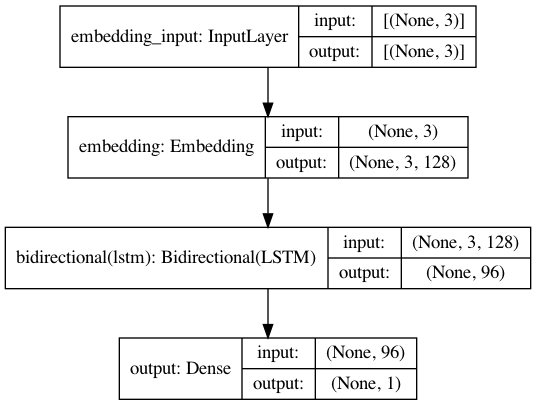

In [66]:
plot_model(models[0], show_shapes=True)

In [67]:
## Retrieve the summary of results from the tuner
tuner.results_summary()

### Explanation

### Train Model with the Tuned Hyperparameters

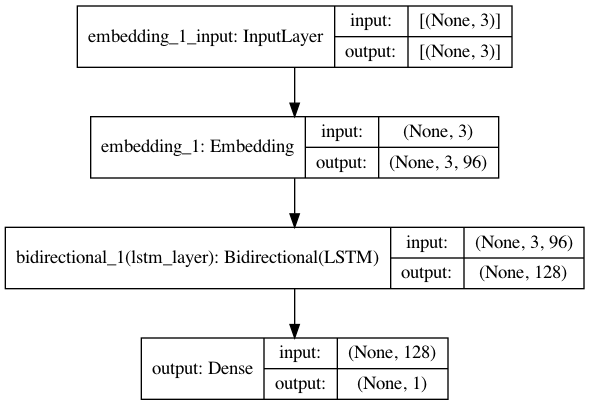

In [68]:
EMBEDDING_DIM =  96
model6 = Sequential()
model6.add(Embedding(input_dim=vocab_size, 
                     output_dim=EMBEDDING_DIM, 
                     input_length=max_len, 
                     mask_zero=True))
model6.add(layers.Bidirectional(LSTM(64, activation="relu", name="lstm_layer", dropout=0.2, recurrent_dropout=0.2)))
model6.add(Dense(1, activation="sigmoid", name="output"))

model6.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)
plot_model(model6, show_shapes=True)

In [69]:
history6 = model6.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/5
300/300 - 21s - loss: 0.1175 - accuracy: 0.9692 - val_loss: 0.0176 - val_accuracy: 0.9942
Epoch 2/5
300/300 - 16s - loss: 0.0135 - accuracy: 0.9954 - val_loss: 0.0088 - val_accuracy: 0.9973
Epoch 3/5
300/300 - 15s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0056 - val_accuracy: 0.9987
Epoch 4/5
300/300 - 14s - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0044 - val_accuracy: 0.9991
Epoch 5/5
300/300 - 14s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0051 - val_accuracy: 0.9991


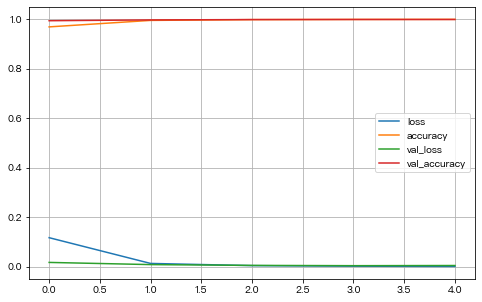

In [70]:
plot2(history6)

### Interpret the Model

In [71]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['Male'], char_level=True)

In [72]:
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    #return np.array([[float(1-x), float(x)] for x in model.predict(np.array(_seq_pad))])
    return model2.predict(np.array(_seq_pad))



# np.array(sequence.pad_sequences(
#     tokenizer.texts_to_sequences([n for (n,l) in test_set]),
#     maxlen = max_len)).astype('float32')

In [73]:
reversed_word_index = dict([(index, word) for (word, index) in tokenizer.word_index.items()])

In [74]:
text_id =305

In [75]:
X_test[text_id]

array([  8, 748, 134], dtype=int32)

In [76]:
X_test_texts[text_id]

'楊慕天'

In [77]:
' '.join([reversed_word_index.get(i, '?') for i in X_test[text_id]])

'楊 慕 天'

In [78]:
model_predict_pipeline([X_test_texts[text_id]])

array([[0.9980952]], dtype=float32)

In [79]:
exp = explainer.explain_instance(
X_test_texts[text_id], model_predict_pipeline, num_features=100, top_labels=1)
exp.show_in_notebook(text=True)

In [80]:
exp = explainer.explain_instance(
'陳宥欣', model_predict_pipeline, num_features=100, top_labels=1)
exp.show_in_notebook(text=True)

In [81]:
exp = explainer.explain_instance(
'李安芬', model_predict_pipeline, num_features=2, top_labels=1)
exp.show_in_notebook(text=True)

In [82]:
exp = explainer.explain_instance(
'林月名', model_predict_pipeline, num_features=2, top_labels=1)
exp.show_in_notebook(text=True)

In [83]:
exp = explainer.explain_instance(
'蔡英文', model_predict_pipeline, num_features=2, top_labels=1)
exp.show_in_notebook(text=True)